# TO DO List
1. Get the 'Average customer ratings' for comfort, cleanliness, location, quality
1. Do a scatter plot of distance from sydney vs bookings count???
1. Distance vs revenue?
1. Distance vs revenue per person (assuming full occupancy)
1. Percentage occupancy for the month vs distance
1. 30/60/90 day occupancy vs distance (forward bookings)
1. Last 30/60/90 day actual occupance vs distance (history bookings)
1. Count how many places have zero bookings

In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
#date_str = datetime.datetime.now().strftime("%Y-%m-%d")

date_str = '2018-05-31'

print("Date: " + date_str)

Date: 2018-05-31


## Dataset 1 - nsw_extract
Load the nsw_extract daily file. This starts with the https://www.stayz.com.au/accommodation/nsw page and then follows the link to each propert. This is the quick (30 minutes) extract of raw details, as it excludes the calendar details.

In [3]:
# Read the data file and display
nsw_extract_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json')

# Reindex for 'property_id'
nsw_extract_2 = nsw_extract_1.set_index('property_id')

nsw_extract_3 = nsw_extract_2.sort_index()

nsw_extract = nsw_extract_3


print("nsw_extract index: " + str(nsw_extract.index.dtype_str))

nsw_extract.head()

nsw_extract index: int64


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,,
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.066400,150.67400,Cottage,29,2018-05-31 01:06:07,S,201,128,https://www.stayz.com.au//accommodation/nsw/so...
2564,3,4,5,[PLEASE NOTE CHANGES TO ALL NEW BOOKINGS - 7 S...,352,8,Long Reef Beach House,694,-35.013200,150.82500,House,27,2018-05-31 01:15:11,S,195,118,https://www.stayz.com.au//accommodation/nsw/so...
3333,1,1,3,[Lakeview Plaza Motel standard rooms are great...,194,4,Lakeview Plaza Motel standard,250,-36.415800,148.62100,Motel,5,2018-05-31 01:03:56,SW,220,356,https://www.stayz.com.au//accommodation/nsw/sn...
4121,2,2,3,"[This property is a holiday rental, it is not ...",411,6,Seashells - relax in comfort with views,165,-34.919876,150.76453,House,23,2018-05-31 01:18:20,S,200,110,https://www.stayz.com.au//accommodation/nsw/so...
4219,1,1,2,[Well maintained and comfortable 3½ star motel...,161,2,Forest Lodge Motor Inn & Restaurant,122,-32.242450,148.63153,Motel,2,2018-05-31 01:05:31,NW,308,306,https://www.stayz.com.au//accommodation/nsw/ex...


## Dataset 2 - Geocode Addresses
Load the full geocoded address file. This is the Google reverse geocoder API output for each of the latitude/longitude details for each property. Note that the street number is not exact for the property but is within a few houses and is the same street. Stayz deliberatly obfuscates the exact location however all other details are correct apart from house number.

In [4]:
# Read the data file and display
geodata_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_full.json')

geodata_2 = geodata_1.set_index('property_id')
geodata_3 = geodata_2.sort_index()

geodata = geodata_3


print("geodata index: " + str(geodata.index.dtype_str))

geodata.head(10)

geodata index: int64


,council,formatted_address,postcode,st_name,st_nbr,state,suburb
property_id,,,,,,,
52,Gosford,"24 Avoca Dr, Avoca Beach NSW 2251, Australia",2251,Avoca Dr,24,NSW,Avoca Beach
717,Pittwater,"342 Whale Beach Rd, Palm Beach NSW 2108, Austr...",2108,Whale Beach Rd,342,NSW,Palm Beach
806,Great Lakes,"5 Coast Ave, Boomerang Beach NSW 2428, Australia",2428,Coast Ave,5,NSW,Boomerang Beach
1036,Gosford,"15 Ficus Ave, Avoca Beach NSW 2251, Australia",2251,Ficus Ave,15,NSW,Avoca Beach
1266,Shoalhaven,"42 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,42,NSW,Vincentia
1873,Shoalhaven,"182 Elizabeth Dr, Vincentia NSW 2540, Australia",2540,Elizabeth Dr,182,NSW,Vincentia
1971,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake
1971,Great Lakes,"30 Ski Cove St, Smiths Lake NSW 2428, Australia",2428,Ski Cove St,30,NSW,Smiths Lake
2040,Shoalhaven,"6 Bellbird Cl, Mollymook Beach NSW 2539, Austr...",2539,Bellbird Cl,6,NSW,Mollymook Beach


## Dataset 3 - Bookings data
This is extracted from the raw data in the nsw_calendar extracts, and each booking details are calculated including arrival date, and number of nights booked. We can aggregate this for each property.

In [5]:
# Read the bookings file
bk_date_str = date_str

#book_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json',convert_dates=['arr_dt','dep_dt'])
# Read the CSV file generated from Postgres. This has the corrected date splits over the month
# It ignores bookings more than 7 days in length
# It also has all the months from Feb 2018 until May 2018
book_1 = pd.read_csv('/Users/taj/GitHub/scraping/stayz_analysis/orange_large_month_summary.csv')

book_1.head()
# Change the index to property id
book_2 = book_1.set_index('property_id')

# Sort the dataset so that all property id bookings are together
book_3 = book_2.sort_index()


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
book_3['book_type'] = book_3['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

book_cust_1 = book_3[book_3['book_type'] == 'Cust']

# Get the dates which are after the date_str

#-------------- data in csv is now the history data, split correctly by mth value


# Only take the next 30 days and see how many bookings there are in total
#date_1 = datetime.datetime.strptime(date_str, "%Y-%m-%d")

#date_30 = date_1 + datetime.timedelta(days=29)

# This gives 30 days inclusive of the start date
#print(date_30.strftime('29 Days time is %d, %b %Y'))

#book_cust_2 = book_cust_1[book_cust_1['arr_dt'] >= date_1]
#book_cust_3 = book_cust_2[book_cust_2['arr_dt'] <= date_30]

book_cust_1.head()

book_cust = book_cust_1

book_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49793 entries, 52 to 9228676
Data columns (total 4 columns):
mth           49793 non-null int64
book_days     49793 non-null int64
book_count    49793 non-null int64
book_type     49793 non-null object
dtypes: int64(3), object(1)
memory usage: 1.9+ MB


In [6]:
# Calculate the number of booked days for the 'Cust' type of bookings since b3 is the customers exc hosts
#book_sum = book_cust.groupby(['property_id']).sum()

# Rename the column as total_booked_days
#book_sum.columns = ['total_booked_days']

book_sum = book_cust

book_sum.head()

#print("book_sum index: " + str(book_sum.index.dtype_str))

#book_sum.info()

,mth,book_days,book_count,book_type
property_id,,,,
52,3,5,2,Cust
52,4,1,1,Cust
528,3,3,1,Cust
528,4,1,1,Cust
717,3,8,3,Cust


In [7]:
# Check a specific property_id to make sure the individual bookings are calculated correctly
a = book_cust.loc[8131]

a
#a.sort_values(by=['arr_dt'])

,mth,book_days,book_count,book_type
property_id,,,,
8131,3,7,2,Cust
8131,4,6,2,Cust
8131,5,10,3,Cust


## Dataset 4 - Calendar


In [8]:
# Read the Calendar extract to get additional details
cal_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_calendar/stayz_calendar_' + date_str + '.json.zip')

# Change values of -1.0 into NaN for stats analysis
cal_1.loc[cal_1['review_count'] == -1.0, 'review_count'] = np.nan
cal_1.loc[cal_1['review_value'] == -1.0, 'review_value'] = np.nan

cal_2 = cal_1.drop(['calendar'], axis=1)

cal_3 = cal_2[(cal_2['property_id'] != 0) & (cal_2['property_id'] != '')]

cal_4 = cal_3

cal_4['property_id'] = cal_4['property_id'].astype(np.int64)

cal_5 = cal_4.set_index(['property_id'])

cal_6 = cal_5.sort_index()

cal = cal_6

cal.head()


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ext_at,features,photos,review_count,review_value
property_id,,,,,
6262,2018-05-31 10:30:31,Balcony\nChildren welcome\nDVD player\nGames\n...,24,6.0,4.7
12584,2018-05-31 10:20:37,Child's high chair\nClothes dryer\nCot\nDVD pl...,7,6.0,4.5
18350,2018-05-31 10:03:33,Air conditioning\nBooks\nCeiling fan\nChild's ...,6,115.0,4.7
24798,2018-05-31 09:29:25,Balcony\nCeiling fan\nChild's high chair\nChil...,19,47.0,5.0
27108,2018-05-31 10:13:45,Air conditioning\nBooks\nCeiling fan\nChild's ...,6,80.0,4.7


## Dataset 5 - Features matrix

In [9]:
# Load the features CSV
feat_1 = pd.read_csv('/Users/taj/GitHub/scraping/stayz/WebData/nsw_features/stayz_nsw_features_' + date_str + '.csv')

feat_2 = feat_1.set_index('Unnamed: 0')

feat_2.index.names = ['property_id']

feat = feat_2

feat.head()

,f_air_conditioning,f_balcony,f_books,f_child_s_high_chair,f_children_welcome,f_coffee_maker,f_dining,f_dishes_and_utensils,f_dishwasher,f_games,...,f_hot_tub,f_heated_pool,f_events_allowed,f_communal_pool,f_indoor_pool,f_sauna,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi
property_id,,,,,,,,,,,,,,,,,,,,,
9191650.0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9067504.0,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9140176.0,0,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9060221.0,0,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9050878.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Create a derived table to map the property_type to an integer
prop_type_table_1 = pd.DataFrame(nsw_extract['property_type'].unique())
prop_type_table_1.columns = ['property_type']

# Reset the index so we can filter on 'property_type'
#prop_type_table_1.reset_index(inplace=True)


# Remove the following property types:
# - Campervan
# - Caravan
# - Hotel
# - Motel
# - Other
# - Resort
# - Yacht

prop_type_table_2 = prop_type_table_1[~prop_type_table_1['property_type'].isin(['Campervan','Caravan','Hotel','Motel'
                                                                             ,'Other','Resort','Yacht'])]

# Add a column with the property type id as a generated number
prop_type_table_2['prop_type_id'] = range(len(prop_type_table_2))

#prop_type_table_2.drop(['prop_type_count'])

prop_type_table = prop_type_table_2

prop_type_table.head(25)


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,property_type,prop_type_id
0,Cottage,0
1,House,1
3,Apartment,2
4,Townhouse,3
5,B&B,4
6,Villa,5
7,Cabin,6
8,Guest,7
9,Studio,8
10,Farmstay,9


In [11]:
# Extract the council, postcode, and suburb unique values and convert to integer:

# Join back to 'geodata' and keep the property_id!!!

council_1 = pd.DataFrame(geodata['council'].unique())
council_1.columns = ['council']
council_1['council_id'] = range(len(council_1))

council_1.head()

,council,council_id
0,Gosford,0
1,Pittwater,1
2,Great Lakes,2
3,Shoalhaven,3
4,Blue Mountains,4


In [12]:
# Extract the council, postcode, and suburb unique values and convert to integer:

suburb_1 = pd.DataFrame(geodata['suburb'].unique())
suburb_1.columns = ['suburb']
suburb_1['suburb_id'] = range(len(suburb_1))

suburb_1.head()

,suburb,suburb_id
0,Avoca Beach,0
1,Palm Beach,1
2,Boomerang Beach,2
3,Vincentia,3
4,Smiths Lake,4


In [13]:
#geodata_1 = geodata.merge()

# Join with property type, keeping property id as the index type
geodata_1 = (geodata.reset_index()
             .merge(council_1, how='left', on=['council'])
             .set_index('property_id')
            )

geodata_2 = (geodata_1.reset_index()
             .merge(suburb_1, how='left', on=['suburb'])
             .set_index('property_id')
            )

geodata_3 = geodata_2[['postcode','council_id','suburb_id']]



geodata_rev = geodata_3

geodata_rev.tail()

,postcode,council_id,suburb_id
property_id,,,
9228588,2251,0,0
9228590,2577,9,58
9228599,2488,12,244
9228610,2448,39,124
9228676,2481,8,108


## Dataset 6 - Page Position

In [14]:
# Read the c_nsw_extract to get the page position

page_pos_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/c_stayz_nsw_extract_' + date_str + '.json')

page_pos_2 = page_pos_1.set_index(['property_id'])

page_pos_3 = page_pos_2.drop(['scraped_date'],axis=1)

page_pos = page_pos_3

page_pos.head()

,page_nbr,page_pos
property_id,,
103178,1,50
9191650,1,1
9137508,1,1
103169,1,49
9177246,1,50


## NSW Data Set
Perform some filtering and data cleansing to get the basic data set ready.

The output is the 'nsw_data' parameter

In [15]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_extract.loc[nsw_extract['guests'] <= 6]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Filter for 2 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['bedrooms'] <= 2 ]

# Filter where straight line distance to Sydney between 80-150km
nsw_data_s4 = nsw_data_s3.loc[(nsw_data_s3['syd_dist_km'] >= 100) & (nsw_data_s3['syd_dist_km'] <= 250)]

# Only look at North properties
nsw_data_s5 = nsw_data_s4.loc[(nsw_data_s4['syd_brg'] == 'SW')]


# Use this to switch between the full dataset or a specific subset
#nsw_data = nsw_data_s5

In [16]:
# Filter out the outliers or ridiculous values
nsw_data_a1 = nsw_extract.loc[nsw_extract['init_price'] <= 10000 ]
nsw_data_a2 = nsw_data_a1.loc[nsw_data_a1['guests'] <= 14 ]
nsw_data_a3 = nsw_data_a2.loc[nsw_data_a2['syd_dist_km'] <= 1000 ]
nsw_data_a4 = nsw_data_a3.loc[nsw_data_a3['init_price'] > 0 ]


# Exclude properties within Sydney
nsw_data_a5 = nsw_data_a4.loc[nsw_data_a4['syd_dist_km'] > 50 ]


# Use this to write out the full dataset
nsw_data = nsw_data_a5

nsw_data.describe()


,bathrooms,bedrooms,beds,description_wc,guests,init_price,lat,lng,reviews,syd_brg_deg,syd_dist_km
count,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000,14525.000000
mean,1.779828,2.903201,4.147608,192.458657,6.534802,251.422169,-33.013246,151.409286,6.149604,115.019484,267.410671
std,0.883767,1.162443,2.125625,109.196102,2.546641,201.308084,2.431852,1.594652,12.694312,103.969901,188.881277
min,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,-41.461440,141.443710,0.000000,0.000000,51.000000
25%,1.000000,2.000000,3.000000,113.000000,5.000000,132.000000,-35.040000,150.466020,0.000000,22.000000,122.000000
50%,2.000000,3.000000,4.000000,166.000000,6.000000,196.000000,-33.300297,151.420300,1.000000,33.000000,194.000000
75%,2.000000,4.000000,5.000000,243.000000,8.000000,300.000000,-31.439861,152.825150,6.000000,203.000000,370.000000
max,30.000000,30.000000,100.000000,784.000000,14.000000,3614.000000,-27.438309,153.636810,197.000000,359.000000,935.000000


In [17]:
# Testing - look in detail at any outliers

t1 = nsw_data.loc[nsw_data['init_price'] >= 1000]
t1.head()

,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,property_type,reviews,scraped_date,syd_brg,syd_brg_deg,syd_dist_km,url
property_id,,,,,,,,,,,,,,,,,
61798,3,6,9,['Cuttagee' is situated less than five minutes...,149,12,Cuttagee - luxury on the South Coast,1257,-34.763412,150.66990,House,12,2018-05-31 01:19:12,SW,208,97,https://www.stayz.com.au//accommodation/nsw/so...
92370,3,5,8,"[BOND: $2000 Payable on arrival, NB: Further d...",143,10,Alantiem,1595,-32.340940,152.54140,House,0,2018-05-31 01:17:40,NE,35,222,https://www.stayz.com.au//accommodation/nsw/no...
93319,3,4,6,[Arguably one of the best Winda Woppa residenc...,47,10,Extraordinary Views - 91A The Boulevarde,1186,-32.678050,152.16820,House,0,2018-05-31 01:09:50,NE,32,172,https://www.stayz.com.au//accommodation/nsw/no...
101790,4,6,10,[Something quite special and unique. Spectacul...,378,14,Number 10 Bannister Mollymook,1015,-35.319000,150.47100,House,59,2018-05-31 01:20:48,SW,203,161,https://www.stayz.com.au//accommodation/nsw/so...
112005,3,5,5,"[Luxuriously decorated with comfort in mind, V...",283,9,"Verandahs- Amazing gardens, spacious and private.",1020,-28.631075,153.47818,House,1,2018-05-31 01:06:04,N,20,634,https://www.stayz.com.au//accommodation/nsw/no...


Total number of properties: 14525


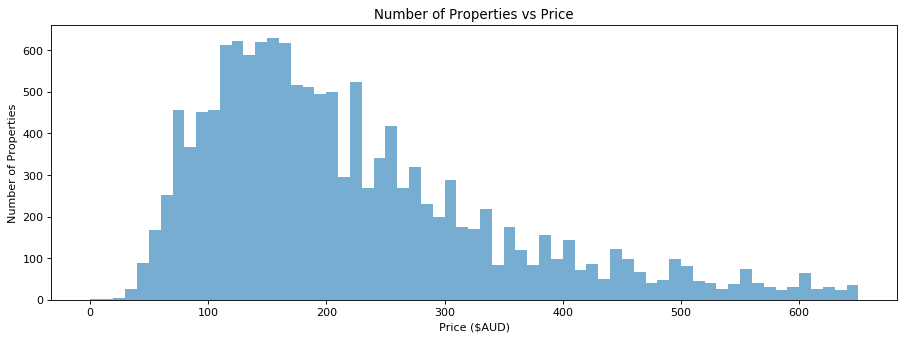

In [18]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=660, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')


# Get the initial price
x = nsw_data['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

print("Total number of properties: " + str(len(x)))

# Plot a histogram of the init_price
ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

Text(0,0.5,'Count')

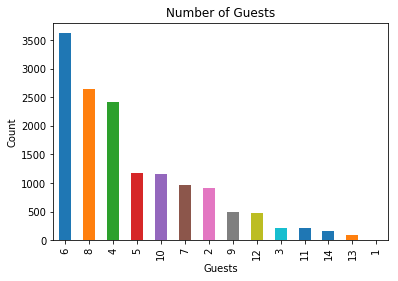

In [19]:
nsw_data['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [20]:
nsw_data['guests'].groupby(nsw_data['guests']).count()

guests
1        3
2      915
3      215
4     2412
5     1173
6     3627
7      964
8     2642
9      492
10    1159
11     204
12     481
13      85
14     153
Name: guests, dtype: int64

## Combined Data Set

Merge the 4 data files together to get the complete picture.
* nsw_data
* geodata
* cal
* book_sum

In [21]:
# Merge the nsw_extract with the geocoded data: only need the postcode, council, suburb. 
# Convert them to integer values first


full_dataset_1 = nsw_data.merge(geodata_rev, how='left', left_index=True, right_index=True)

full_dataset_2 = full_dataset_1.merge(cal, how='left', left_index=True, right_index=True)

full_dataset_3 = full_dataset_2.merge(book_sum, how='left', left_index=True, right_index=True)

full_dataset_4 = full_dataset_3.merge(feat, how='left', left_index=True, right_index=True)

# Join with property type, keeping property id as the index type
full_dataset_5 = (full_dataset_4.reset_index()
                  .merge(prop_type_table, how='inner', on=['property_type'])
                  .set_index('property_id')
                 )

#full_dataset_5['total_booked_days'][0:5]

full_dataset_5.head()


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,...,f_heated_pool,f_events_allowed,f_communal_pool,f_indoor_pool,f_sauna,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,prop_type_id
property_id,,,,,,,,,,,,,,,,,,,,,
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.066400,150.67400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.066400,150.67400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.066400,150.67400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1873,3,6,8,"[Large home with 6 bedrooms 1 with ensuite, 2 ...",135,13,Mana magic - 182 Elizabeth Drive,561,-35.066400,150.67400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5544,1,3,5,['Avoca' is a heritage homestead destination o...,240,6,Avoca-on-Darling Hospitality,179,-33.930573,141.96753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [22]:
# Drop some unnecessary columns
#full_dataset_5.drop(columns=['lat', 'lng','syd_brg','scraped_date','property_type','features','url','description_full','heading'],inplace=True)

# Replace any 'NaN' values with zeros
full_dataset_5.fillna(0,inplace=True)

# Sort based on the total booked days for the current 6 month window, sort descending
#full_dataset_6 = full_dataset_5.sort_values(by=['property_id'], ascending=False)

full_dataset_6 = full_dataset_5.merge(page_pos, how='left', left_index=True, right_index=True)


# Replace the number of days with only the bucket. For 30 day predictions we have 7 buckets as:
# 0 - No bookins
# 1 - 1-5 days booked
# 2 - 6-10 days booked
# 3 - 11-15 days
# 4 - 16-20 days
# 5 - 21-25 days
# 6 - 26-30 days


#full_dataset_6['days_booked_bucket'] = (full_dataset_6['total_booked_days']//15)
#full_dataset_6.drop(['total_booked_days'],axis=1,inplace=True)



# Drop Property_ID and Postcode and Extracted_At date, Reviews and Review_Count are duplicates drop one
# Drop the council ID, the postcode should be enough identifier

full_dataset_7 = full_dataset_6.drop(['postcode','ext_at','reviews','council_id'],axis=1)


# Calculate the revenue
full_dataset_7['revenue'] = full_dataset_7['init_price'] * full_dataset_7['book_days']


full_dataset = full_dataset_7


In [24]:
# Write out the full dataset

csv_out = full_dataset.to_csv()

fh = open('/Users/taj/GitHub/scraping/stayz/WebData/nsw_fulldata/stayz_nsw_fulldata_' + date_str + '.csv', 'w')

fh.write(csv_out)

fh.close()

In [25]:
# Find which suburb is Orange
org = suburb_1[suburb_1['suburb'] == 'Mudgee']

# Suburb ID's
# Orange = 165
# Mudgee = 41
# Buckaroo = 683

p1 = suburb_1.loc[165]
p1

suburb       Orange
suburb_id       165
Name: 165, dtype: object

In [63]:
# Find all the unique 10+ guest houses in orange

o10_1 = full_dataset[full_dataset['suburb_id'] == 165]

o10_2 = o10_1[o10_1['guests'] >= 10].index.unique()

o10_2

# 6 Unique property_id's: 9062114, 9137336, 9148674, 9168471, 9169308, 9199601

Int64Index([9062114, 9137336, 9148674, 9168471, 9169308, 9199601], dtype='int64', name='property_id')

In [57]:
# Find all houses of 10 guests or more in orange

o10_1 = full_dataset[full_dataset['suburb_id'] == 165]

o10_2 = o10_1[o10_1['guests'] >= 10]

o10_3 = o10_2[['bathrooms','bedrooms','guests','init_price','mth','revenue']]

o10_3.sort_values(by=['mth','revenue'])

,bathrooms,bedrooms,guests,init_price,mth,revenue
property_id,,,,,,
9148674,1,4,10,175,2.0,350.0
9148674,1,4,10,175,3.0,875.0
9199601,4,6,12,807,3.0,2421.0
9168471,4,6,12,1033,3.0,3099.0
9062114,2,4,11,610,3.0,3660.0
9137336,2,6,14,350,3.0,4200.0
9169308,2,4,10,390,3.0,4290.0
9137336,2,6,14,350,4.0,350.0
9169308,2,4,10,390,4.0,1560.0


Total number of properties: 70
[ 1 12 11  9  7  5  7  4  5  1  3  4  1  0  0]


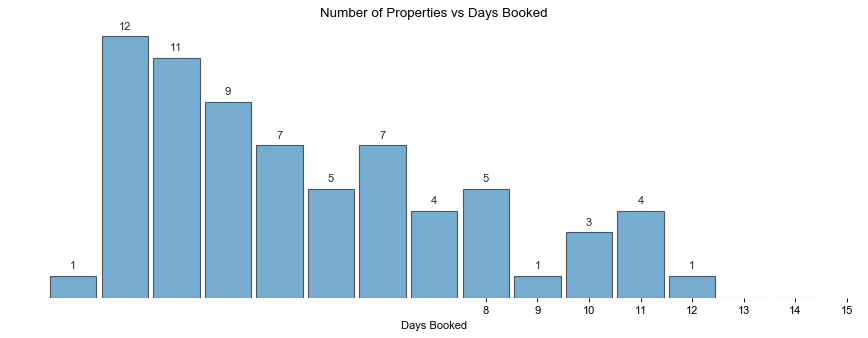

In [26]:
# Histogram of how many properties get bookings



# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=16, step=1)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)

rects = ax.patches


plt.xticks(np.arange(min(x), 16, 1))
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))

plt.style.use('seaborn-white')

ax.set(title='Number of Properties vs Days Booked'
      ,xlabel='Days Booked'
      ,ylabel='Number of Properties')

ax.patch.set_facecolor('#FFFFFF')

ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)

# Get the initial price
a1 = full_dataset[full_dataset['mth'] == 4]

a2 = a1[a1['suburb_id'].isin([165])]['book_days']


x = a2

#x2 = full_dataset[full_dataset['guests'] > 8]


# Remove the rows where price is empty (NaN)
x = x.dropna()

ax.hist(x, bins=bin_values-0.5, alpha=.6, edgecolor='black', rwidth=0.9) # alpha for transparency


print("Total number of properties: " + str(len(x)))


counts, bin_edges = np.histogram(x, bins=bin_values)


print(counts)


# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bin_values) + bin_values[:-1]

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:d}".format(int(y_value))

    # Create annotation
    if( y_value > 0 ):
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            #color='black',
            #size=14,
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
# Plot a histogram of the init_price
#x.plot(kind='bar', alpha=.6) # alpha for transparency


plt.show()

In [27]:
t1 = full_dataset[full_dataset['mth'] == 2]

t2 = t1[t1['suburb_id'].isin([165])]

t3 = t2[t2['guests'] > 8]

t4 = t3[['lat','lng','bathrooms','bedrooms','guests','init_price','book_days','mth','revenue']]

t4.sort_values(by=['revenue']).head()

,lat,lng,bathrooms,bedrooms,guests,init_price,book_days,mth,revenue
property_id,,,,,,,,,
9148674,-33.2841,149.108,1,4,10,175,2.0,2.0,350.0


The best properties across Feb to June with highest consistent revenues are:

1. *9062114* - BELL HILL, ORANGE, NSW (\$610)
1. *9137336* - YOURSTAY GROUP THE EDWARD TOWNHOUSES (\$350)
1. *9148674* - YOURSTAY GROUP THE DORA HALL (\$175)
1. *9168471* - MAGNIFICENT "WILLOWOOD," ORANGE (\$1087)
1. *9169308* - HAMER HOUSE IN CENTRAL ORANGE - ENTIRE HOUSE (\$390)
1. *9199601* - LARGE & LUXURIOUS HERITAGE HOUSE - CENTRAL ORANGE (\$807)


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


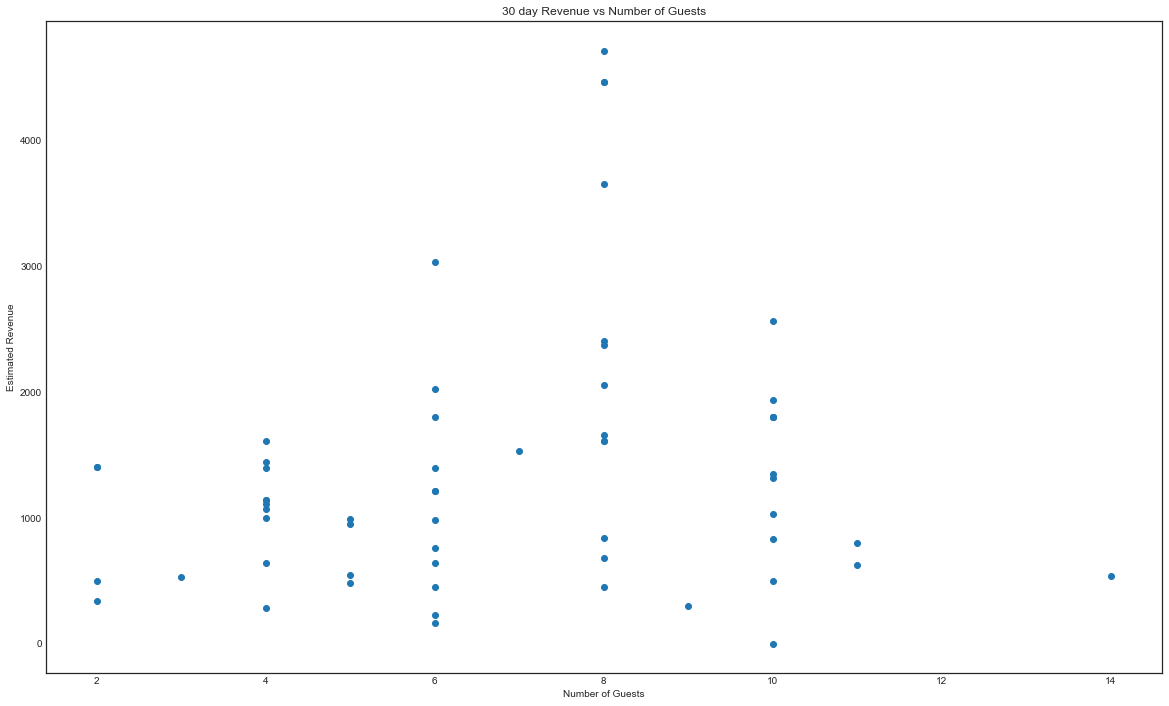

In [28]:
# Plot the bookings vs the initial price

#plot_ds = full_dataset[full_dataset['total_booked_days'] > 0]

# Plot the Orange suburb
plot_ds_2 = full_dataset[full_dataset['suburb_id'].isin([683,41])]

plot_ds_3 = plot_ds_2[plot_ds_2['mth'] == 4]

plot_ds_3['revenue'] = plot_ds_3['init_price'] * plot_ds_3['book_days']


#plot_ds_3.info()

plt.figure(figsize=(20,12))

plt.title('30 day Revenue vs Number of Guests')
plt.xlabel('Number of Guests')
plt.ylabel('Estimated Revenue')
plt.scatter(plot_ds_3['guests'],plot_ds_3['revenue'])

plt.show()

In [29]:
# Get the top 10 by revenue
rev10 = full_dataset[full_dataset['suburb_id'].isin([165])]

rev10a = rev10.sort_values(by=['revenue'],ascending=False)

rev10a.head(5)


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,...,f_indoor_pool,f_sauna,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,prop_type_id,page_nbr,page_pos,revenue
property_id,,,,,,,,,,,,,,,,,,,,,
9168471,4,6,10,[This outstanding home boasts 4 double bedroom...,318,12,"Magnificent ""Willowood,"" Orange",1033,-33.300297,149.14983,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,8.0,12396.0
9169308,2,4,7,[Hamer House serviced accommodation is your 'h...,179,10,Hamer House in Central Orange - Entire House,390,-33.283104,149.08710,...,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,4290.0
9137336,2,6,8,"[ACCOMMODATION OF CHOICE, AND AS SEEN IN THE P...",238,14,Yourstay Group The Edward Townhouses,350,-33.287900,149.10576,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,18.0,4200.0
9168471,4,6,10,[This outstanding home boasts 4 double bedroom...,318,12,"Magnificent ""Willowood,"" Orange",1033,-33.300297,149.14983,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,8.0,4132.0
9062114,2,4,8,"[""BELL HILL"" is a private retreat, nestled on ...",211,11,"BELL HILL, Orange, NSW",610,-33.189600,149.05100,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,49.0,3660.0


Text(23.4211,0.5,'Revenue ($)')

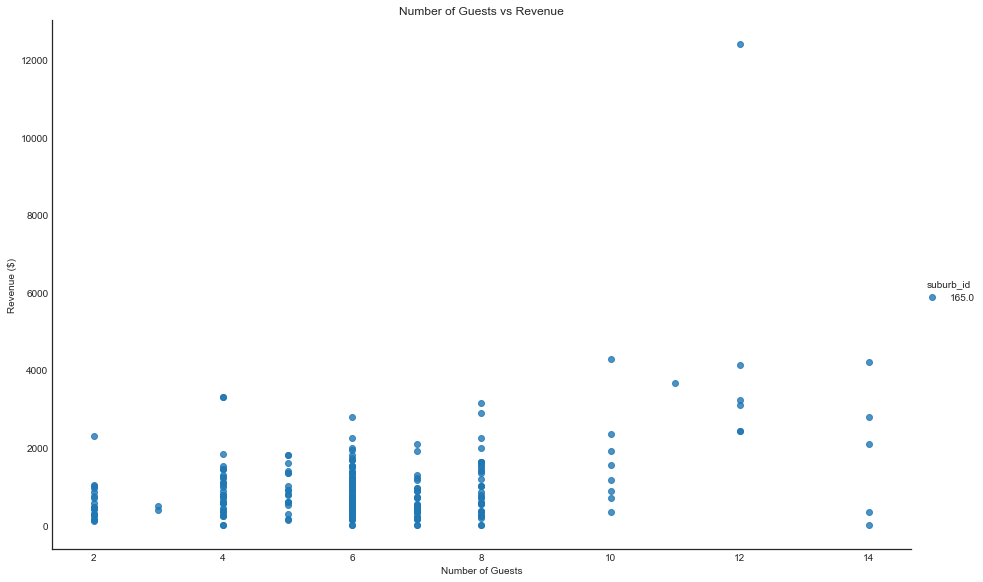

In [49]:
# Now check individual graphs in detail
ax = sns.lmplot( x="guests", y="revenue", data=rev10a, fit_reg=False
           , hue='suburb_id'
           , aspect=1.61
          , size=8)

ax = plt.gca()
ax.set_title("Number of Guests vs Revenue")
ax.set_xlabel("Number of Guests")
ax.set_ylabel("Revenue ($)")

In [31]:
a1 = full_dataset.loc[9202601]

a1


plot_ds_2.head()


,bathrooms,bedrooms,beds,description_full,description_wc,guests,heading,init_price,lat,lng,...,f_indoor_pool,f_sauna,f_pantry_items,f_cot,f_eco_friendly,f_free_wifi,prop_type_id,page_nbr,page_pos,revenue
property_id,,,,,,,,,,,,,,,,,,,,,
27675,1,3,3,[Colonial Court Villas are walking distance fr...,113,8,Colonial Court Villas,189,-32.589400,149.57700,...,0.0,0.0,0.0,0.0,0.0,0.0,2,3.0,24.0,1134.0
27675,1,3,3,[Colonial Court Villas are walking distance fr...,113,8,Colonial Court Villas,189,-32.589400,149.57700,...,0.0,0.0,0.0,0.0,0.0,0.0,2,3.0,24.0,567.0
168649,1,3,4,"[Charming cottage in a quiet Mudgee street, ju...",113,6,21 on Lawson in the centre of Mudgee,262,-32.593037,149.59360,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,19.0,524.0
211800,1,4,4,"[Located a few minutes to Mudgee CBD, Enjoy th...",74,7,Mudgee Escape - relax unwind discover,306,-32.583110,149.56712,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,25.0,612.0
211800,1,4,4,"[Located a few minutes to Mudgee CBD, Enjoy th...",74,7,Mudgee Escape - relax unwind discover,306,-32.583110,149.56712,...,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,25.0,1224.0


In [33]:
# Show the top 10 highest revenue earners

plot_ds_3 = plot_ds_2.sort_values(by='revenue', ascending=False)

plot_ds_3[['bedrooms','beds','guests','init_price','photos','book_days','revenue']].head()

,bedrooms,beds,guests,init_price,photos,book_days,revenue
property_id,,,,,,,
9214387,5,5,10,647,0.0,12.0,7764.0
9166132,5,6,10,856,24.0,9.0,7704.0
9166132,5,6,10,856,24.0,8.0,6848.0
9210788,4,4,10,1000,0.0,6.0,6000.0
9191213,5,6,10,600,0.0,10.0,6000.0


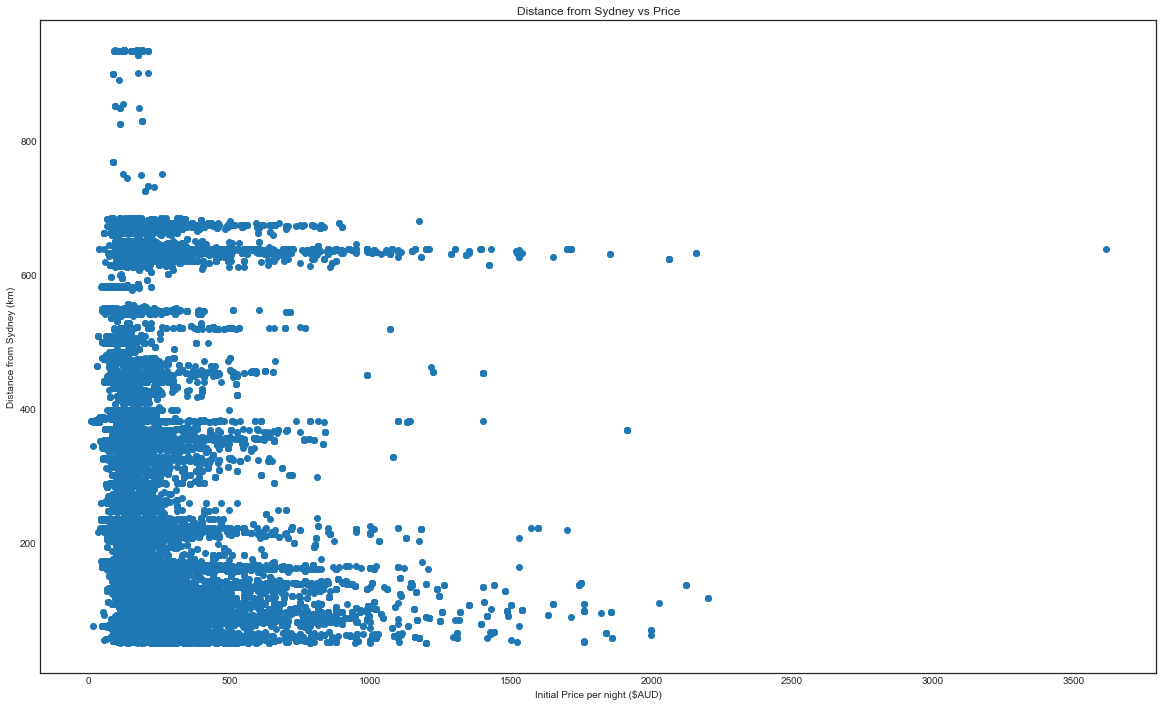

In [34]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))


#nsw_data_s6 = nsw_data_s5[nsw_data_s5['syd_dist_km'] <= 250]

#nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_dataset['init_price'],full_dataset['syd_dist_km'])

plt.show()

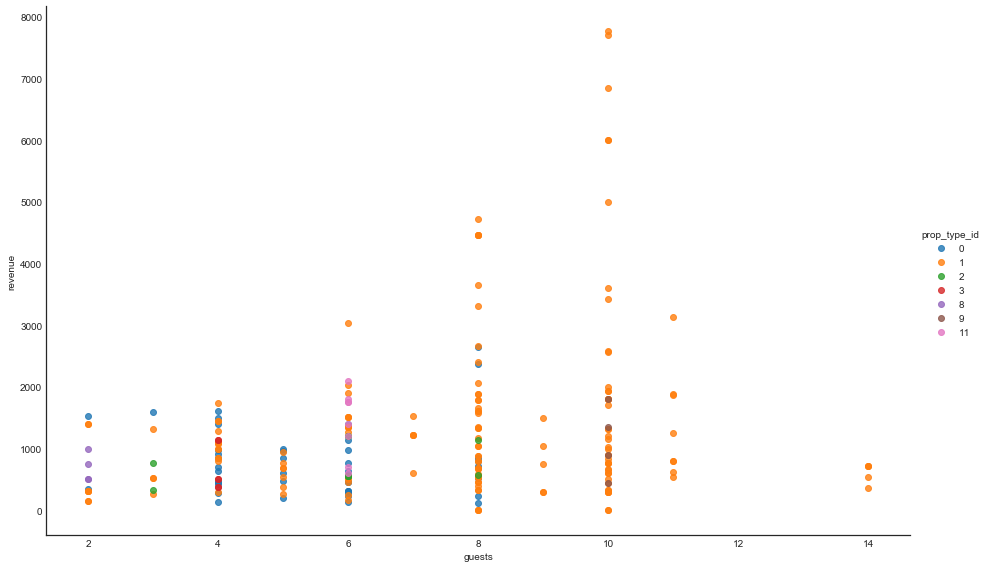

In [48]:
# Now check individual graphs in detail
sns.lmplot( x="guests", y="revenue", data=plot_ds_2, fit_reg=False
           , hue='prop_type_id'
           , aspect=1.61
          , size=8)


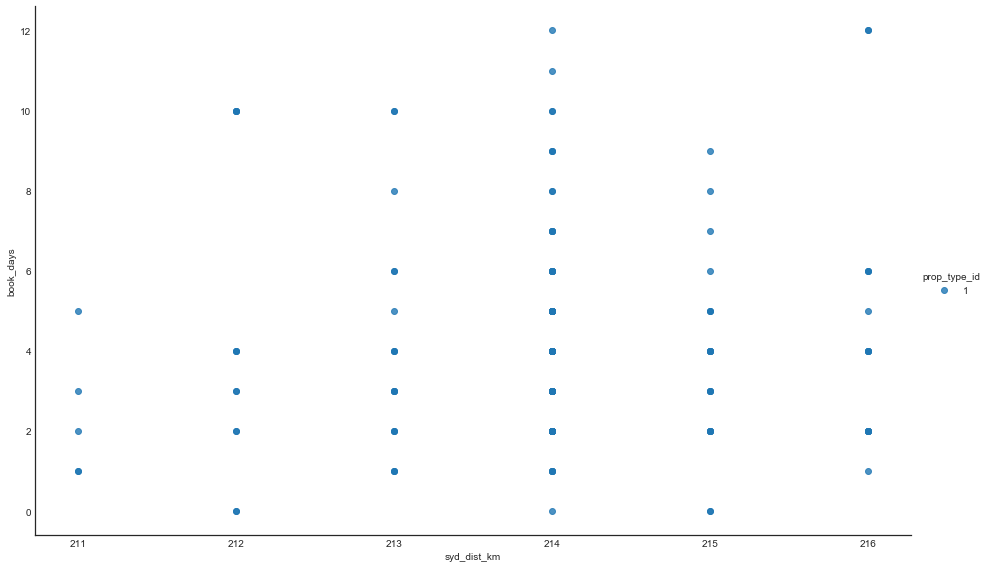

In [42]:
# Now check individual graphs in detail

# Try just one property_type - House

nsw_data_s8 = plot_ds_2[plot_ds_2['prop_type_id'] == 1]

sns.lmplot( x="syd_dist_km", y="book_days", data=nsw_data_s8, fit_reg=False
           , hue='prop_type_id'
           , aspect=1.61
          , size=8)

In [ ]:
#test_cor = full_dataset.corr(method='pearson')

#test_cor

In [46]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
#plot_corr(full_dataset)